First, let's import the modules we need.

In [47]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import json
import os
import random
from tensorflow.keras.models import load_model


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
NUM_CLIENTS = 51
NUM_CLASSES = 18
ALPHA = 0.6
LOCAL_EPOCHS = 1
FL_ENABLED = True
NUM_ROUNDS = 5
import tensorflow as tf

Let's define some helper functions to segment the timeseries data to segments of 25 datapoints, with each having a 10-datapoint overlap with the previous and next segments. All the segments have purely the same activity label.

In [34]:
import numpy as np

def segment_data(df, window_size=50, step_size=25):
    segments = []
    labels = []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        segment = df.iloc[start:end]
        if len(segment) == window_size:
            segment_data = segment[["x", "y", "z"]].values
            segments.append(segment_data)
            label = segment["activity"].mode()[0]
            labels.append(label)
    return np.array(segments), np.array(labels)

def segment_each_activity(df, window_size=25, step_size=15):
    all_segments = []
    all_labels = []
    for activity in df["activity"].unique():
        activity_data = df[df["activity"] == activity]
        
        segments, labels = segment_data(activity_data, window_size, step_size)
        
        all_segments.append(segments)
        all_labels.append(labels)

    all_segments = np.concatenate(all_segments, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_segments, all_labels


Read the data and encode the activity label, do this same for each user and make a big array consisting of these local datasets. Also, let's create a dictionary to create human-readable labels for the activities according to the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf).

In [35]:
activity_dict = {1: "Walking", 2: "Jogging", 3: "Stairs", 4: "Sitting", 5: "Standing",
    6: "Typing", 7: "Brushing Teeth", 8: "Eating Soup", 9: "Eating Chips",
    10: "Eating Pasta", 11: "Drinking from Cup", 12: "Eating Sandwich",
    13: "Kicking (Soccer Ball)", 14: "Playing Catch w/Tennis Ball",
    15: "Dribbling (Basketball)", 16: "Writing", 17: "Clapping", 18: "Folding Clothes"
}

datasets = []
lencoder = LabelEncoder()

for uid in range(1600, 1600 + NUM_CLIENTS):
    ds = pd.read_csv(f"./raw/phone/accel/data_{uid}_accel_phone.txt", header=None, names=["user", "activity", "timestamp", "x", "y", "z"])
    ds["activity"] = lencoder.fit_transform(ds["activity"])
    ds["z"] = ds["z"].astype(str).str.replace(";", "", regex=False).astype(float)
    seg_X, seg_y = segment_each_activity(ds)
    X_train, X_test, y_train, y_test = train_test_split(seg_X, seg_y, test_size=0.3, shuffle=True, random_state=42)
    X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)
    sample_size = 1.0
    sample_size_train = int(sample_size * len(X_train))
    sample_size_test = int(sample_size * len(X_test))
    sample_size_validation = int(sample_size * len(X_validation))

    X_train = X_train[:sample_size_train]
    y_train = y_train[:sample_size_train]

    X_test = X_test[:sample_size_test]
    y_test = y_test[:sample_size_test]

    X_validation = X_validation[:sample_size_validation]
    y_validation = y_validation[:sample_size_validation]

    
    datasets.append([X_train, y_train, X_test, y_test, X_validation, y_validation])

Let's create some helper functions for the next steps.

In [45]:
def create_sparse_graph(num_clients=NUM_CLIENTS, k=5):
    G = nx.Graph()
    for i in range(num_clients):
        G.add_node(i)

    for i in range(num_clients):
        possible_neighbors = list(set(range(num_clients)) - {i} - set(G.neighbors(i)))
        random_neighbors = random.sample(possible_neighbors, min(k, len(possible_neighbors)))
        for j in random_neighbors:
            G.add_edge(i, j)
    
    
    return G

# Create and return a basic nx graph
def create_graph():
    G = create_sparse_graph(NUM_CLIENTS, 5)
    for i, (X_train, y_train, X_test, y_test, X_validation, y_validation) in enumerate(datasets):
        G.nodes[i]['X_train'] = X_train
        G.nodes[i]['y_train'] = y_train
        G.nodes[i]['X_test'] = X_test
        G.nodes[i]['y_test'] = y_test
        G.nodes[i]['X_validation'] = X_validation
        G.nodes[i]['y_validation'] = y_validation
    return G

# Create a basic CNN mode with number of our classes
def create_model(input_shape, num_classes=18):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', name='conv1')(inputs)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', name='conv2')(x)
    x = tf.keras.layers.Conv1D(16, 3, activation='relu', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='dense')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def compute_gtvmin_pair(model1, model2):

    shared_layer_names1 = [model1.layers[1].get_weights()[0], model1.layers[2].get_weights()[0]]
    shared_layer_names2 = [model2.layers[1].get_weights()[0], model2.layers[2].get_weights()[0]]
    
    weights1 = flatten_weights(shared_layer_names1)
    weights2 = flatten_weights(shared_layer_names2)

    diff = weights1 - weights2
    gtv = np.sum(diff ** 2)
    return gtv

# Function for calculating a GTV loss - we need the current node model + its idx, and graph
def calculate_gtv_loss(model, graph, node_idx):
    gtv_loss = 0
    for j in graph.neighbors(node_idx):
        neigh = graph.nodes[j]
        if 'model' in neigh:
            gtv_loss += compute_gtvmin_pair(neigh['model'], model)
    return gtv_loss




# Function for training the model with GTV-Min
def train_model_with_gtv(model, X_train, y_train, graph, node_idx, model_array, epochs=LOCAL_EPOCHS, alpha=ALPHA):
    optimizer = tf.keras.optimizers.Adam()
    ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
    
    for epoch in range(epochs):
        gtv_error = calculate_gtv_loss(model, graph, node_idx)
        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)
                ce_loss = ce_loss_fn(y_batch, y_pred)
                
                total_loss = ce_loss + alpha * gtv_error
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

def get_shared_weights(model, layer_names=['conv1d_1281', 'conv1d_1282']):
    return [model.get_layer(name).get_weights() for name in layer_names]

def flatten_weights(layer_weights):
    return np.concatenate([w.flatten() for w in layer_weights])

In [49]:
G = create_graph()

def local_train_and_get_weights(i, G, r, model_array):
    node = G.nodes[i]
    X_train, y_train, X_validation, y_validation = node['X_train'], node['y_train'], node['X_validation'], node['y_validation']
    model_path = f"./models/round{r}_node{i}.keras"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    
    if r == 0:
        if os.path.exists(model_path):
            print(f"Loading existing model for Node {i} from round {r}")
            model = load_model(model_path)
        else:
            model = create_model(input_shape=X_train.shape[1:])
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=LOCAL_EPOCHS, batch_size=32, verbose=0)
        

        model_array[i] = model
        loss, acc = model.evaluate(X_validation, y_validation, verbose=0)
        print(f"Node {i}: Loss={loss:.4f}, Accuracy={acc:.4f}")
        model.save(model_path)
        return loss, acc
    else:
        model_copy = tf.keras.models.clone_model(node['model'])
        train_model_with_gtv(model_copy, X_train, y_train, G, i, alpha=ALPHA, model_array=model_array)
        model_array[i] = model_copy
        model_copy.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, acc = model_copy.evaluate(X_validation, y_validation, verbose=0)
        print(f"Node {i}: Loss={loss:.4f}, Accuracy={acc:.4f}")
        return loss, acc
            
errors = {}            

for r in range(NUM_ROUNDS):
    model_array = [None] * NUM_CLIENTS
    round_losses = []
    round_accuracies = []

    for i in G.nodes:
        loss, acc = local_train_and_get_weights(i, G, r, model_array)
        errors.setdefault(f"Round (r)", []).append([loss, acc])
        round_losses.append(loss)
        round_accuracies.append(acc)
    
    avg_loss = sum(round_losses) / len(round_losses)
    avg_acc = sum(round_accuracies) / len(round_accuracies)
    print(avg_loss, "avg loss")
    print(avg_acc, " avg acc")
    
    for i in G.nodes:
        node = G.nodes[i]
        node['model'] = model_array[i]


try:
    with open('errors.json', 'w') as f:
        json.dump(errors, f)
        

    os.makedirs("saved_models", exist_ok=True)

    for i in G.nodes:
        model = G.nodes[i]['model']
        model.save(f"saved_models/client_{i}.h5")  # HDF5 format

    print("\n=== Final Evaluation on Validation Sets ===")
    final_results = {}

    for i in G.nodes:
        model = G.nodes[i]['model']
        node = G.nodes[i]
        X_val, y_val = node['X_test'], node['y_test']
        
        loss, acc = model.evaluate(X_val, y_val, verbose=0)
        final_results[f"client_{i}"] = {"loss": float(loss), "accuracy": float(acc)}
        print(f"Client {i}: Final Loss={loss:.4f}, Accuracy={acc:.4f}")

    # Save final test results
    with open("final_test_results.json", "w") as f:
        json.dump(final_results, f, indent=2)
        
except Exception:
    os.makedirs("saved_models", exist_ok=True)

    for i in G.nodes:
        model = G.nodes[i]['model']
        model.save(f"saved_models/client_{i}.h5")  # HDF5 format

Loading existing model for Node 0 from round 0


KeyboardInterrupt: 

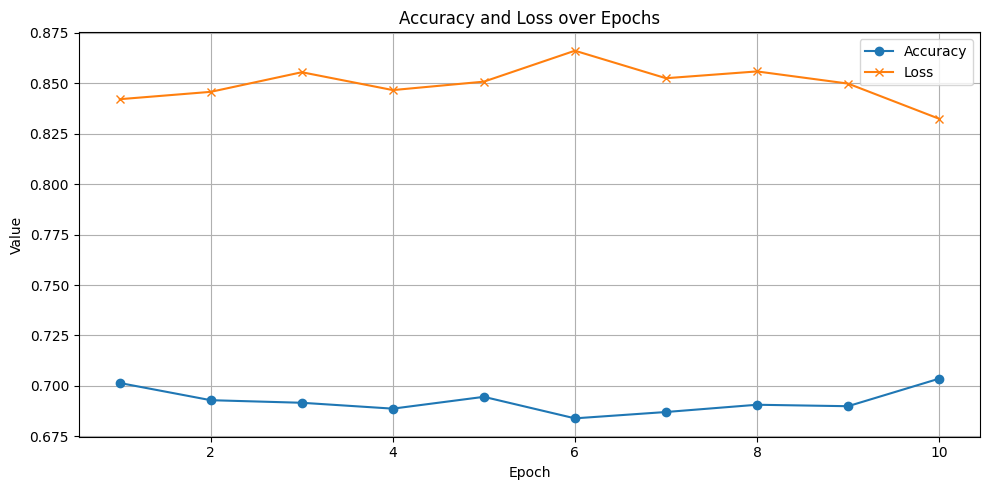

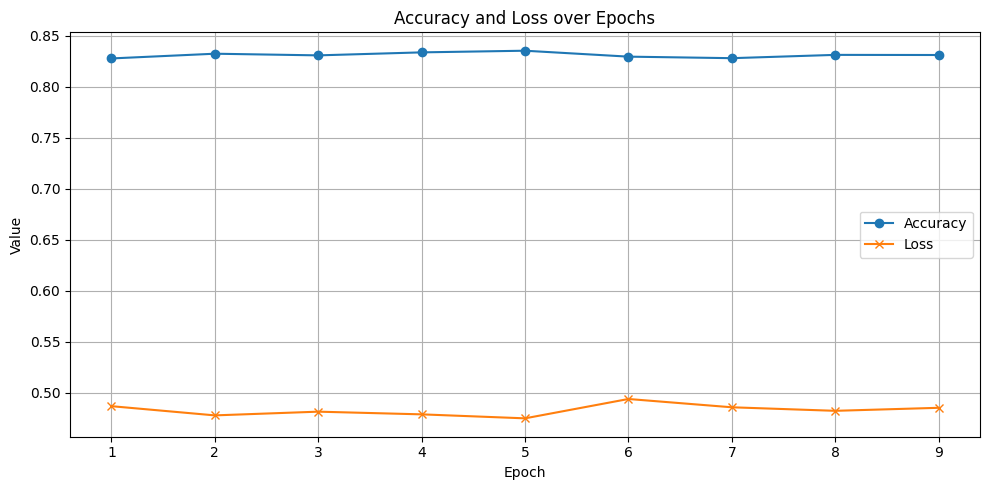

In [44]:
results = [
    [0.8421578705310822, 0.7014463964630576],
    [0.8458056011620689, 0.6929163628933477],
    [0.8555330593211978, 0.6916400509722093],
    [0.8466728160194322, 0.6887261832461637], 
    [0.8508602404126934, 0.6945829222015306], 
    [0.8661944649967492, 0.6839201047140009],
    [0.8525574084590463, 0.6870585200833339],
    [0.8559259012633679, 0.6906579937420639],
    [0.849900098992329, 0.6899334630545448],
    [0.8324742615222931, 0.7035826532279744]
]

losses = [r[0] for r in results]
accuracies = [r[1] for r in results]
epochs = list(range(1, len(results) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, losses, label='Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_loss_plot.jpg')
plt.show()

plt.savefig('accuracy_loss_plot.jpg', dpi=300)
plt.close()

results2 = [
    [0.4868982174232894, 0.8279608967257481],
    [0.4778665930909269, 0.8325983332652672],
    [0.4815087379778133, 0.8309765610040403], 
    [0.4788760516573401, 0.8339175500121772], 
    [0.47496413556384104, 0.8355417497017804],
    [0.49394411783592373, 0.8297220328274895],
    [0.4858107087658901, 0.8282255565418917],
    [0.48234011262070897, 0.8314604782590679],
    [0.4852970958340402, 0.831332689406825]
]

losses = [r[0] for r in results2]
accuracies = [r[1] for r in results2]
epochs = list(range(1, len(results2) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, losses, label='Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_loss_plot.jpg')
plt.show()

plt.savefig('accuracy_loss_plot.jpg', dpi=300)
plt.close()